In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [9]:
data=pd.read_csv("C:/semi_project/health_checkup/JDM/2022년~2023년/건강데이터_2012_2023_합본.csv")

In [10]:
import pandas as pd

# 전체 데이터 불러오기 (예: data)
# data = pd.read_csv("건강검진_2012~2023.csv")

# 2019, 2020년 데이터만 추출
data = data[data["year"].isin([2019, 2020])].copy()

# 고혈압 4단계 기준 리매핑 함수 (2022년 기준)
def remap_hypertension(sbp, dbp):
    if sbp < 120 and dbp < 80:
        return 1  # 정상
    elif 120 <= sbp < 130 and dbp < 80:
        return 2  # 주의
    elif 130 <= sbp < 140 and dbp < 90:
        return 3  # 고혈압 전단계
    else:
        return 4  # 고혈압

# 고혈압 클래스 생성
data["hypertension_class"] = data.apply(
    lambda row: remap_hypertension(row["HE_sbp1"], row["HE_dbp1"]), axis=1
)

# 클래스 분포 확인
print(data["hypertension_class"].value_counts().sort_index())


hypertension_class
1    6098
2    1392
3    1429
4    6550
Name: count, dtype: int64


In [11]:
# 1. 2019~2020 중 클래스 2, 3만 필터링
data_selected = data[
    (data["year"].isin([2019, 2020])) &
    (data["hypertension_class"].isin([2, 3]))
].copy()

# 2. 변수명 맞춰주기: hypertension_class → HE_HP
data_selected["HE_HP"] = data_selected["hypertension_class"]
data_selected.drop(columns=["hypertension_class"], inplace=True)

# 2. 2022~2023 데이터도 불러오기 (예시)
data=pd.read_csv("C:/semi_project/health_checkup/JDM/2022년~2023년/건강데이터_2022_2023_합본.csv")


# 3. 두 데이터 합치기
data_combined = pd.concat([data, data_selected], axis=0).reset_index(drop=True)


In [7]:
data_combined

ID    year  region  town_t  sex   age  incm  ho_incm  edu  \
0         YA01220302  2022.0     1.0     1.0  2.0  56.0   3.0      4.0  3.0   
1         YA01220303  2022.0     1.0     1.0  1.0  30.0   3.0      4.0  4.0   
2         YA01220304  2022.0     1.0     1.0  2.0  25.0   3.0      4.0  4.0   
3         YA01236501  2022.0     1.0     1.0  1.0  66.0   3.0      3.0  4.0   
4         YA01236502  2022.0     1.0     1.0  2.0  62.0   3.0      3.0  3.0   
...              ...     ...     ...     ...  ...   ...   ...      ...  ...   
16010  b'R804330901'  2020.0     8.0     1.0  1.0  42.0   3.0      3.0  4.0   
16011  b'R804330902'  2020.0     8.0     1.0  2.0  41.0   3.0      3.0  4.0   
16012  b'R804353001'  2020.0     8.0     1.0  2.0  30.0   2.0      3.0  4.0   
16013  b'R804366601'  2020.0     8.0     1.0  2.0  61.0   2.0      3.0  3.0   
16014  b'R804371702'  2020.0     8.0     1.0  2.0  57.0   1.0      2.0  3.0   

       occp  cfam  genertn  D_1_1  DI1_dg  DI1_ag  DI1_pr  DI1_pt  DI1_2  \
0       7.0   4.0      4.0    3.0     1.0    48.0     1.0     1.0    1.0   
1       3.0   4.0      4.0    2.0     0.0   888.0     8.0     8.0    8.0   
2       7.0   4.0      4.0    2.0     0.0   888.0     8.0     8.0    8.0   
3       7.0   2.0      2.0    2.0     0.0   888.0     8.0     8.0    8.0   
4       6.0   2.0      2.0    2.0     0.0   888.0     8.0     8.0    8.0   
...     ...   ...      ...    ...     ...     ...     ...     ...    ...   
16010   1.0   4.0      4.0    2.0     0.0   888.0     8.0     8.0    8.0   
16011   1.0   4.0      4.0    2.0     0.0   888.0     8.0     8.0    8.0   
16012   1.0   1.0      1.0    3.0     0.0   888.0     8.0     8.0    8.0   
16013   6.0   2.0      5.0    3.0     0.0   888.0     8.0     8.0    8.0   
16014   3.0   2.0      2.0    4.0     0.0   888.0     8.0     8.0    8.0   

       DI2_dg  DI2_ag  DI2_pr  DI2_pt  DI2_2  DE1_dg  DE1_ag  DE1_pr  DE1_pt  \
0         0.0   888.0     8.0     8.0    8.0     0.0   888.0     8.0     8.0   
1         0.0   888.0     8.0     8.0    8.0     0.0   888.0     8.0     8.0   
2         0.0   888.0     8.0     8.0    8.0     0.0   888.0     8.0     8.0   
3         1.0    56.0     1.0     1.0    1.0     0.0   888.0     8.0     8.0   
4         1.0    53.0     1.0     1.0    1.0     0.0   888.0     8.0     8.0   
...       ...     ...     ...     ...    ...     ...     ...     ...     ...   
16010     0.0   888.0     8.0     8.0    8.0     0.0   888.0     8.0     8.0   
16011     0.0   888.0     8.0     8.0    8.0     0.0   888.0     8.0     8.0   
16012     0.0   888.0     8.0     8.0    8.0     0.0   888.0     8.0     8.0   
16013     0.0   888.0     8.0     8.0    8.0     0.0   888.0     8.0     8.0   
16014     0.0   888.0     8.0     8.0    8.0     0.0   888.0     8.0     8.0   

       DE1_3  DE1_31  DE1_32  DE1_33  DE1_34  DE1_4  DN1_dg  DN1_ag  BH1  BO1  \
0        8.0     8.0     8.0     8.0     8.0    8.0     0.0   888.0  1.0  4.0   
1        8.0     8.0     8.0     8.0     8.0    8.0     0.0   888.0  1.0  4.0   
2        8.0     8.0     8.0     8.0     8.0    8.0     0.0   888.0  2.0  4.0   
3        8.0     8.0     8.0     8.0     8.0    8.0     0.0   888.0  1.0  3.0   
4        8.0     8.0     8.0     8.0     8.0    8.0     0.0   888.0  1.0  3.0   
...      ...     ...     ...     ...     ...    ...     ...     ...  ...  ...   
16010    8.0     8.0     8.0     8.0     8.0    8.0     0.0   888.0  1.0  3.0   
16011    8.0     8.0     8.0     8.0     8.0    8.0     0.0   888.0  1.0  4.0   
16012    8.0     8.0     8.0     8.0     8.0    8.0     0.0   888.0  1.0  5.0   
16013    8.0     8.0     8.0     8.0     8.0    8.0     0.0   888.0  1.0  5.0   
16014    8.0     8.0     8.0     8.0     8.0    8.0     0.0   888.0  1.0  4.0   

       BO1_1  BO2_1  BD1  BD1_11  BD2_1  BP16_1  BP16_2  BP1  BP5  BS1_1  \
0        1.0    1.0  2.0     1.0    8.0     8.0    10.0  2.0  8.0    3.0   
1        3.0    1.0  2.0     3.0    2.0     7.0     7.0  3.0  8.0    3

In [12]:
# 클래스 분포 확인
print(data["HE_HP"].value_counts().sort_index())

HE_HP
1.0    4772
2.0     882
3.0    1552
4.0    3803
Name: count, dtype: int64


In [13]:
print(set(data.columns) ^ set(data_selected.columns))

{'AC3_2_02', 'BE3_23', 'source_year', 'E_NWT', 'HE_Ucot_etc', 'LK_EDU', 'HE_THfh2', 'LQ_5EQL', 'BS6_4_1', 'AC8_1e_02', 'BA2_14', 'DJ4_pt', 'BE3_94', 'DM3_pr', 'DM1_dg', 'HE_df', 'BS12_42', 'T_Q_CR', 'AC8_2w_03', 'mh_PHQ_S', 'BM13_5', 'DC2_ag', 'AC8_3_04', 'E_RVO', 'AC8_2w_05', 'BM2_3', 'DC12_pt', 'ho_incm5', 'BS12_47_2', 'DI6_lt', 'AC8_3_10', 'E_MH_r', 'mh_stress', 'BM1_8', 'T_IM_C_L', 'BH1_7', 'T_VHIT_EX_R', 'T_HRM_RT', 'TLS_B1', 'T_HR_EX_L_1', 'LF_S13', 'BP_PHQ_7', 'HE_HPfh3', 'DM1_5', 'BH2_61', 'E_RVO_l', 'BS14_11', 'BE3_92', 'BP6_2', 'BP16_21', 'T_IM_B_L', 'E_DO', 'n_day', 'BD2_14', 'h_school_t', 'DM1_pr', 'BS5_3', 'wt_hm', 'DJ4_83', 'T_HR1000_LT', 'EC_lgw_2', 'HE_dog', 'LF_S3', 'LW_mt_f1', 'DE1_51', 'L_DN', 'T_Q_ALLE', 'T_VHIT_EX_L', 'N_B1', 'LF_secur_y', 'HE_tb4_d', 'E_Dr_dcyl', 'wt_itvex', 'T_HR500_RT', 'T_EX', 'HEI_CHO', 'EC_wh', 'T_Q_DZ7', 'HE_tb4', 'HE_PFTdr', 'T_HR4000_RT', 'AC3_3e_01', 'BH2_64', 'BE3_85', 'HE_Uglu', 'DM4_pt', 'LW_pr', 'BH9_14_2_03', 'E_PO', 'AC3_3_01', 'GS_

In [37]:
import pandas as pd
import numpy as np

# --- 1. 2019년~2020년 데이터 처리 ---
# 2012년~2023년 합본 데이터셋 로드 (2019년, 2020년 데이터 포함)
# 실제 파일 경로에 맞게 수정해주세요.
try:
    all_years_data = pd.read_csv("C:/semi_project/health_checkup/JDM/2022년~2023년/건강데이터_2012_2023_합본.csv")
    print("2012-2023 합본 데이터 로드 성공.")
except FileNotFoundError:
    print("오류: '건강데이터_2012_2023_합본.csv' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    exit() # 파일이 없으면 스크립트 종료

# 2019년, 2020년 데이터만 추출
data_19_20 = all_years_data[all_years_data["year"].isin([2017,2018,2019, 2020])].copy()
print(f"2019년, 2020년 데이터 추출 완료. 행 수: {len(data_19_20)}")

# 고혈압 4단계 기준 리매핑 함수 (2022년 기준)
def remap_hypertension(sbp, dbp):
    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan # 혈압 값이 없는 경우 NaN 반환
    if sbp < 120 and dbp < 80:
        return 1  # 정상
    elif 120 <= sbp < 130 and dbp < 80:
        return 2  # 주의
    elif 130 <= sbp < 140 and dbp < 90:
        return 3  # 고혈압 전단계
    elif sbp >= 140 or dbp >= 90:
        return 4  # 고혈압
    else: # 정의되지 않은 케이스
        return np.nan

# 고혈압 클래스 생성
# 'HE_sbp1'와 'HE_dbp1' 컬럼이 존재하는지 확인
if 'HE_sbp1' in data_19_20.columns and 'HE_dbp1' in data_19_20.columns:
    # 2019-2020년 데이터에 임시로 'hypertension_class' 컬럼 생성
    data_19_20["hypertension_class"] = data_19_20.apply(
        lambda row: remap_hypertension(row["HE_sbp1"], row["HE_dbp1"]), axis=1
    )
    print("2019년, 2020년 데이터 고혈압 클래스 재분류 및 'hypertension_class' 컬럼 생성 완료.")
else:
    print("오류: 'HE_sbp1' 또는 'HE_dbp1' 컬럼이 2019-2020년 데이터에 없습니다.")
    exit()

# 재분류된 데이터에서 클래스 2(주의), 3(고혈압 전단계)만 추출
minority_classes_19_20 = data_19_20[data_19_20["hypertension_class"].isin([2, 3])].copy()
print(f"2019년, 2020년 데이터에서 클래스 2, 3 추출 완료. 행 수: {len(minority_classes_19_20)}")


# --- 2. 기존 2022년~2023년 데이터 로드 및 준비 ---
# 기존 2022년~2023년 데이터셋 로드
# 이 파일도 실제 경로에 맞게 수정해주세요.
try:
    main_data_22_23 = pd.read_csv("C:/semi_project/health_checkup/JDM/2022년~2023년/건강데이터_2022_2023_합본.csv")
    print("2022-2023년 메인 데이터 로드 성공.")
except FileNotFoundError:
    print("오류: '건강데이터_2022_2023_합본.csv' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    exit()

# 기존 2022-2023년 데이터셋의 고혈압 컬럼명을 'hypertension_class'로 통일
# (병합 전에는 'HE_HP'를 'hypertension_class'로 변경하여 컬럼명을 맞춰줌)
main_data_22_23_processed = main_data_22_23.copy()
if 'HE_HP' in main_data_22_23_processed.columns:
    main_data_22_23_processed = main_data_22_23_processed.rename(columns={'HE_HP': 'hypertension_class'})
    print("기존 데이터셋 'HE_HP' 컬럼명을 'hypertension_class'로 변경 완료 (병합 준비).")
else:
    print("경고: 기존 2022-2023년 데이터셋에 'HE_HP' 컬럼이 없습니다. 고혈압 분류 컬럼을 확인해주세요.")
    # 이 경우, main_data_22_23_processed['hypertension_class']를 다시 생성하는 로직이 필요할 수 있습니다.
    # 예: main_data_22_23_processed["hypertension_class"] = main_data_22_23_processed.apply(
    #        lambda row: remap_hypertension(row["HE_sbp1"], row["HE_dbp1"]), axis=1)

# --- 3. 데이터 합치기 (Concatenate) ---
# 두 데이터셋의 공통 컬럼 확인 및 선택
common_columns = list(set(minority_classes_19_20.columns) & set(main_data_22_23_processed.columns))

if 'hypertension_class' not in common_columns:
    print("오류: 'hypertension_class' 컬럼이 공통 컬럼에 포함되어 있지 않습니다. 확인이 필요합니다.")
    exit()

print(f"두 데이터셋의 공통 컬럼 수: {len(common_columns)}")
# 공통 컬럼만 선택하여 병합 수행
merged_data = pd.concat([
    main_data_22_23_processed[common_columns],
    minority_classes_19_20[common_columns]
], ignore_index=True)

print(f"\n데이터 병합 완료. 최종 데이터셋 행 수: {len(merged_data)}")

# --- 4. 최종 컬럼명 변경 ---
# 합쳐진 데이터프레임에서 'hypertension_class'를 'HE_HP'로 다시 변경
if 'hypertension_class' in merged_data.columns:
    merged_data = merged_data.rename(columns={'hypertension_class': 'HE_HP'})
    print("최종 데이터셋의 'hypertension_class' 컬럼을 'HE_HP'로 변경 완료.")
else:
    print("오류: 최종 병합된 데이터셋에 'hypertension_class' 컬럼이 없습니다. 확인이 필요합니다.")


# 최종 병합된 데이터의 고혈압 클래스 ('HE_HP') 분포 확인
print("\n최종 병합된 데이터의 고혈압 클래스 ('HE_HP') 분포:")
print(merged_data["HE_HP"].value_counts(dropna=False))
print("\n클래스별 비율:")
print(merged_data["HE_HP"].value_counts(normalize=True, dropna=False))

# 이제 'merged_data' 데이터프레임을 사용하여 모델 학습을 진행하면 됩니다.
# X = merged_data.drop('HE_HP', axis=1) # 실제 피처 컬럼명으로 수정 필요
# y = merged_data['HE_HP']

# 여기에 모델 학습 및 .pkl 파일 저장 코드를 추가합니다.
# (이전 답변의 주석 처리된 모델 학습 및 저장 코드 참조)

2012-2023 합본 데이터 로드 성공.
2019년, 2020년 데이터 추출 완료. 행 수: 31588
2019년, 2020년 데이터 고혈압 클래스 재분류 및 'hypertension_class' 컬럼 생성 완료.
2019년, 2020년 데이터에서 클래스 2, 3 추출 완료. 행 수: 5602
2022-2023년 메인 데이터 로드 성공.
기존 데이터셋 'HE_HP' 컬럼명을 'hypertension_class'로 변경 완료 (병합 준비).
두 데이터셋의 공통 컬럼 수: 98

데이터 병합 완료. 최종 데이터셋 행 수: 18796
최종 데이터셋의 'hypertension_class' 컬럼을 'HE_HP'로 변경 완료.

최종 병합된 데이터의 고혈압 클래스 ('HE_HP') 분포:
HE_HP
1.0    4772
3.0    4427
4.0    3803
2.0    3609
NaN    2185
Name: count, dtype: int64

클래스별 비율:
HE_HP
1.0    0.253884
3.0    0.235529
4.0    0.202330
2.0    0.192009
NaN    0.116248
Name: proportion, dtype: float64


In [40]:
# 클래스 분포 확인
merged_data["HE_HP"].value_counts().sort_index()

output_file_path = "C:/semi_project/health_checkup/JDM/2022년~2023년/당뇨합치기.csv" # 저장할 경로와 파일명 지정

try:
    # merged_data 데이터프레임을 지정된 경로에 CSV 파일로 저장
    merged_data.to_csv(output_file_path, index=False, encoding='utf-8-sig')
    print(f"\n데이터프레임이 '{output_file_path}' 경로에 성공적으로 저장되었습니다.")
except Exception as e:
    print(f"\n데이터프레임 저장 중 오류 발생: {e}")


데이터프레임이 'C:/semi_project/health_checkup/JDM/2022년~2023년/당뇨합치기.csv' 경로에 성공적으로 저장되었습니다.


In [41]:
data=pd.read_csv("C:/semi_project/health_checkup/JDM/2022년~2023년/당뇨합치기.csv")

In [38]:
data = merged_data.sort_values(by='year')

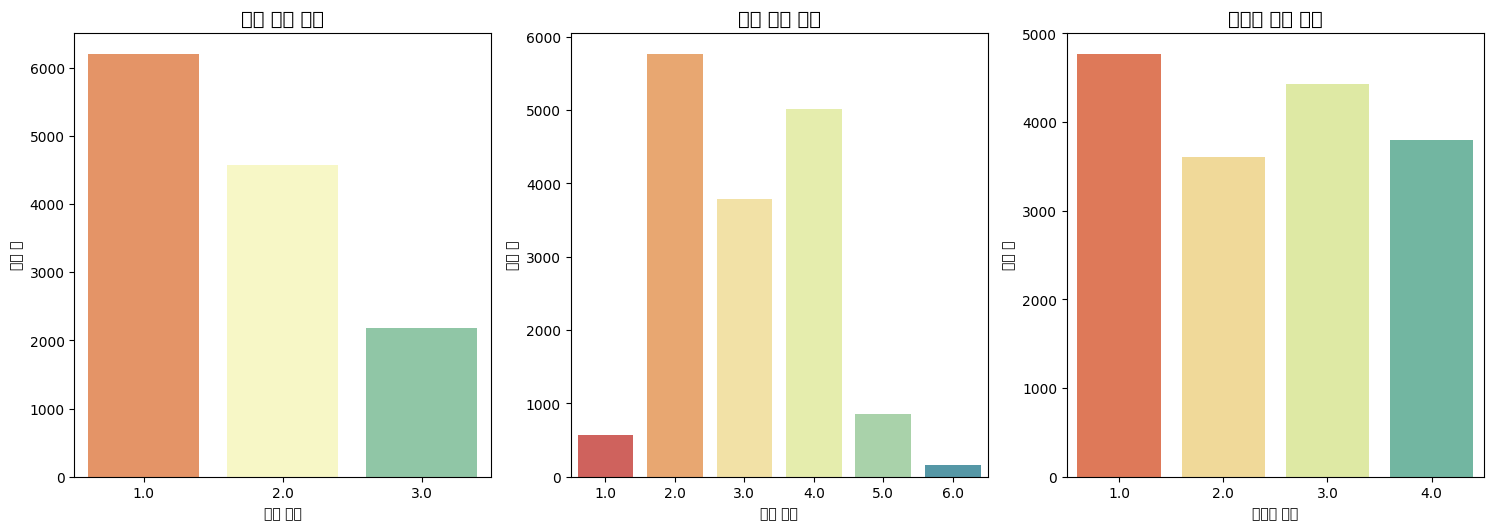

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': '당뇨 여부',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [43]:
import pandas as pd
import numpy as np

# --- 1. 2019년~2020년 데이터 처리 ---
# 2012년~2023년 합본 데이터셋 로드 (2019년, 2020년 데이터 포함)
try:
    all_years_data = pd.read_csv("C:/semi_project/health_checkup/JDM/2022년~2023년/건강데이터_2012_2023_합본.csv")
    print("2012-2023 합본 데이터 로드 성공.")
except FileNotFoundError:
    print("오류: '건강데이터_2012_2023_합본.csv' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    exit()

# 2019년, 2020년 데이터만 추출
data_19_20 = all_years_data[all_years_data["year"].isin([2019, 2020,2021])].copy()
print(f"2019년, 2020년 데이터 추출 완료. 행 수: {len(data_19_20)}")

# --- 고혈압 리매핑 함수는 현재 당뇨 문제에 필요 없으므로 삭제하거나 주석 처리 ---
# def remap_hypertension(sbp, dbp):
#     if pd.isna(sbp) or pd.isna(dbp):
#         return np.nan
#     if sbp < 120 and dbp < 80:
#         return 1
#     elif 120 <= sbp < 130 and dbp < 80:
#         return 2
#     elif 130 <= sbp < 140 and dbp < 90:
#         return 3
#     elif sbp >= 140 or dbp >= 90:
#         return 4
#     else:
#         return np.nan

# 2019-2020년 데이터에서 'HE_DM_HbA1c' 컬럼의 클래스 3만 추출
# (클래스 3이 소수 클래스임을 가정)
if 'HE_DM_HbA1c' in data_19_20.columns:
    minority_classes_19_20 = data_19_20[data_19_20["HE_DM_HbA1c"].isin([3])].copy()
    print(f"2019년, 2020년 데이터에서 당뇨(HE_DM_HbA1c) 클래스 3 추출 완료. 행 수: {len(minority_classes_19_20)}")
else:
    print("오류: 'HE_DM_HbA1c' 컬럼이 2019-2020년 데이터에 없습니다. 당뇨 데이터 처리가 불가능합니다.")
    exit()

# --- 2. 기존 2022년~2023년 데이터 로드 및 준비 ---
# 이전 답변에서 저장한 '당뇨합치기.csv'를 로드
try:
    main_data_22_23 = pd.read_csv("C:/semi_project/health_checkup/JDM/2022년~2023년/당뇨합치기.csv")
    print("2022-2023년 메인 당뇨 데이터 로드 성공.")
except FileNotFoundError:
    print("오류: '당뇨합치기.csv' 파일을 찾을 수 없습니다. 이 파일이 존재해야 합니다.")
    print("혹은 '건강데이터_2022_2023_합본.csv'에서 2022-2023년 데이터를 직접 로드하고 당뇨 기준에 맞게 전처리해야 합니다.")
    exit()

# main_data_22_23_processed 변수 정의 누락 해결
# 여기서는 main_data_22_23 자체를 사용하므로 별도의 copy()나 rename은 필요 없을 수 있습니다.
# 만약 '당뇨합치기.csv'에 'HE_DM_HbA1c' 외 다른 컬럼명이 당뇨 분류를 나타낸다면 여기서 rename이 필요합니다.
main_data_22_23_processed = main_data_22_23.copy() # 변수 정의 누락 해결

# --- 3. 데이터 합치기 (Concatenate) ---
# 두 데이터셋의 공통 컬럼 확인 및 선택
# 당뇨 분류 컬럼이 'HE_DM_HbA1c'임을 명시
common_columns = list(set(minority_classes_19_20.columns) & set(main_data_22_23_processed.columns))

if 'HE_DM_HbA1c' not in common_columns:
    print("오류: 'HE_DM_HbA1c' 컬럼이 공통 컬럼에 포함되어 있지 않습니다. 데이터셋의 컬럼들을 확인해주세요.")
    print("minority_classes_19_20 컬럼:", minority_classes_19_20.columns.tolist())
    print("main_data_22_23_processed 컬럼:", main_data_22_23_processed.columns.tolist())
    exit()

print(f"두 데이터셋의 공통 컬럼 수: {len(common_columns)}")
# 공통 컬럼만 선택하여 병합 수행
merged_data = pd.concat([
    main_data_22_23_processed[common_columns],
    minority_classes_19_20[common_columns]
], ignore_index=True)

print(f"\n데이터 병합 완료. 최종 데이터셋 행 수: {len(merged_data)}")

# 최종 병합된 데이터의 당뇨 클래스 ('HE_DM_HbA1c') 분포 확인
print("\n최종 병합된 데이터의 당뇨 클래스 ('HE_DM_HbA1c') 분포:")
print(merged_data["HE_DM_HbA1c"].value_counts(dropna=False))
print("\n클래스별 비율:")
print(merged_data["HE_DM_HbA1c"].value_counts(normalize=True, dropna=False))

# --- 4. 최종 데이터프레임을 CSV 파일로 저장 (필요시) ---
output_file_path_final = "C:/semi_project/health_checkup/JDM/2022년~2023년/최종_당뇨_고혈압_합본.csv" # 저장할 경로와 파일명 지정 (더 명확하게)
try:
    merged_data.to_csv(output_file_path_final, index=False, encoding='utf-8-sig')
    print(f"\n최종 데이터프레임이 '{output_file_path_final}' 경로에 성공적으로 저장되었습니다.")
except Exception as e:
    print(f"\n데이터프레임 저장 중 오류 발생: {e}")

# 이제 'merged_data' 데이터프레임을 사용하여 당뇨 모델 학습을 진행하면 됩니다.
# X = merged_data.drop('HE_DM_HbA1c', axis=1) # 실제 피처 컬럼명으로 수정 필요
# y = merged_data['HE_DM_HbA1c']

2012-2023 합본 데이터 로드 성공.
2019년, 2020년 데이터 추출 완료. 행 수: 22559
2019년, 2020년 데이터에서 당뇨(HE_DM_HbA1c) 클래스 3 추출 완료. 행 수: 2686
2022-2023년 메인 당뇨 데이터 로드 성공.
두 데이터셋의 공통 컬럼 수: 98

데이터 병합 완료. 최종 데이터셋 행 수: 21482

최종 병합된 데이터의 당뇨 클래스 ('HE_DM_HbA1c') 분포:
HE_DM_HbA1c
1.0    6205
NaN    5842
3.0    4869
2.0    4566
Name: count, dtype: int64

클래스별 비율:
HE_DM_HbA1c
1.0    0.288846
NaN    0.271949
3.0    0.226655
2.0    0.212550
Name: proportion, dtype: float64

최종 데이터프레임이 'C:/semi_project/health_checkup/JDM/2022년~2023년/최종_당뇨_고혈압_합본.csv' 경로에 성공적으로 저장되었습니다.


In [30]:
data = merged_data.sort_values(by='year')

output_file_path = "C:/semi_project/health_checkup/JDM/2022년~2023년/당뇨와 고혈압 합치기.csv" # 저장할 경로와 파일명 지정

try:
    # merged_data 데이터프레임을 지정된 경로에 CSV 파일로 저장
    merged_data.to_csv(output_file_path, index=False, encoding='utf-8-sig')
    print(f"\n데이터프레임이 '{output_file_path}' 경로에 성공적으로 저장되었습니다.")
except Exception as e:
    print(f"\n데이터프레임 저장 중 오류 발생: {e}")


데이터프레임이 'C:/semi_project/health_checkup/JDM/2022년~2023년/당뇨와 고혈압 합치기.csv' 경로에 성공적으로 저장되었습니다.


In [35]:
data=pd.read_csv("C:/semi_project/health_checkup/JDM/2022년~2023년/최종_당뇨_고혈압_합본.csv")

In [32]:
data

,BD2_1,occp,HE_HCHOL,D_1_1,BP1,DE1_4,age,DE1_31,HE_DM_HbA1c,HE_obe,BE3_33,year,DI2_pr,HE_HLfh1,region,HE_sbp1,HE_sbp2,DI1_pt,HE_DMfh2,BS12_37,BE5_1,DE1_34,ID,DI1_ag,HE_Upro,L_OUT_FQ,LS_VEG1,BP16_1,BS12_47,HE_HTG,BP16_2,HE_dbp2,DE1_pr,HE_TG,HE_BUN,BD1_11,incm,HE_Ualb,DN1_dg,BS3_2,BE3_31,HE_HPfh2,BS1_1,town_t,HE_HLfh2,HE_dbp1,HE_wc,HE_crea,DI1_pr,BO2_1,HE_DMfh1,DE1_32,L_DN_FQ,HE_alt,LS_FRUIT,ho_incm,BD1,HE_Ucrea,HE_LDL_drct,HE_BMI,HE_HbA1c,DE1_pt,DI2_ag,L_BR_FQ,sex,HE_fh,DI2_dg,BS12_1,DE1_dg,DE1_3,HE_chol,BO1_1,edu,DI2_2,BE3_32,DE1_33,BE9,HE_HDL_st2,BS3_1,HE_wt,cfam,HE_HPfh1,HE_ast,DN1_ag,BP5,BS12_2,BS12_47_1,genertn,BH1,HE_glu,DI2_pt,DI1_2,BO1,HE_ht,DE1_ag,L_LN_FQ,DI1_dg
0,8.0,7.0,0.0,3.0,2.0,8.0,56.0,8.0,1.0,4.0,30.0,2022.0,8.0,0.0,1.0,135.0,138.0,1.0,0.0,2.0,1.0,8.0,YA01220302,48.0,0.0,5.0,2.0,8.0,8.0,0.0,10.0,89.0,8.0,181.0,13.0,1.0,3.0,9.7,0.0,888.0,5.0,1.0,3.0,1.0,0.0,90.0,84.3,0.61,1.0,1.0,0.0,8.0,1.0,16.0,2.0,4.0,2.0,84.6,122.0,26.507517,5.6,8.0,888.0,3.0,2.0,1.0,0.0,2.0,0.0,8.0,199.0,1.0,3.0,8.0,1.0,8.0,88.0,56.0,8.0,60.6,4.0,0.0,22.0,888.0,8.0,8.0,888.0,4.0,1.0,94.0,8.0,1.0,4.0,151.2,888.0,1.0,1.0
1,2.0,3.0,0.0,2.0,3.0,8.0,30.0,8.0,1.0,4.0,0.0,2022.0,8.0,1.0,1.0,145.0,128.0,8.0,0.0,2.0,6.0,8.0,YA01220303,888.0,0.0,4.0,2.0,7.0,8.0,0.0,7.0,78.0,8.0,63.0,14.0,3.0,3.0,NaN,0.0,888.0,8.0,1.0,3.0,1.0,0.0,77.0,86.2,0.86,8.0,1.0,1.0,8.0,1.0,18.0,3.0,4.0,2.0,54.3,63.0,27.152029,5.3,8.0,888.0,1.0,1.0,1.0,0.0,2.0,0.0,8.0,122.0,3.0,4.0,8.0,3.0,8.0,88.0,48.0,8.0,82.3,4.0,1.0,28.0,888.0,8.0,8.0,888.0,4.0,1.0,84.0,8.0,8.0,4.0,174.1,888.0,1.0,0.0
2,1.0,7.0,0.0,2.0,2.0,8.0,25.0,8.0,1.0,2.0,20.0,2022.0,8.0,1.0,1.0,103.0,104.0,8.0,0.0,2.0,6.0,8.0,YA01220304,888.0,0.0,3.0,2.0,6.0,8.0,NaN,8.0,63.0,8.0,53.0,8.0,4.0,3.0,9.4,0.0,888.0,8.0,1.0,3.0,1.0,1.0,64.0,69.4,0.60,8.0,1.0,1.0,8.0,2.0,15.0,2.0,4.0,2.0,192.4,124.0,21.308131,5.0,8.0,888.0,4.0,2.0,1.0,0.0,2.0,0.0,8.0,202.0,2.0,4.0,8.0,0.0,8.0,88.0,75.0,8.0,59.0,4.0,1.0,17.0,888.0,8.0,8.0,888.0,4.0,2.0,87.0,8.0,8.0,4.0,166.4,888.0,1.0,0.0
3,2.0,7.0,1.0,2.0,4.0,8.0,66.0,8.0,1.0,3.0,30.0,2022.0,1.0,0.0,1.0,116.0,120.0,8.0,0.0,2.0,1.0,8.0,YA01236501,888.0,0.0,4.0,1.0,9.0,8.0,0.0,9.0,78.0,8.0,123.0,18.0,3.0,3.0,NaN,0.0,888.0,8.0,1.0,2.0,1.0,0.0,80.0,83.5,0.90,8.0,2.0,0.0,8.0,1.0,15.0,2.0,3.0,2.0,99.1,74.0,23.577207,5.2,8.0,56.0,1.0,1.0,1.0,1.0,2.0,0.0,8.0,136.0,1.0,4.0,1.0,1.0,8.0,88.0,47.0,3.0,67.1,2.0,0.0,20.0,888.0,8.0,8.0,888.0,2.0,1.0,87.0,1.0,8.0,3.0,168.7,888.0,1.0,0.0
4,1.0,6.0,1.0,2.0,3.0,8.0,62.0,8.0,1.0,2.0,0.0,2022.0,1.0,0.0,1.0,145.0,131.0,8.0,0.0,2.0,4.0,8.0,YA01236502,888.0,0.0,6.0,1.0,7.0,8.0,0.0,9.0,87.0,8.0,110.0,10.0,2.0,3.0,3.3,0.0,888.0,8.0,0.0,3.0,1.0,0.0,89.0,77.5,0.67,8.0,1.0,0.0,8.0,1.0,23.0,2.0,3.0,2.0,46.5,82.0,21.839183,5.6,8.0,53.0,1.0,2.0,1.0,1.0,2.0,0.0,8.0,149.0,1.0,3.0,1.0,1.0,8.0,88.0,53.0,8.0,53.9,2.0,1.0,26.0,888.0,8.0,8.0,888.0,2.0,1.0,91.0,1.0,8.0,3.0,157.1,888.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14976,2.0,7.0,1.0,3.0,3.0,2.0,59.0,0.0,3.0,5.0,30.0,2020.0,1.0,0.0,8.0,134.0,132.0,1.0,0.0,2.0,1.0,0.0,b'R803409102',51.0,0.0,6.0,2.0,5.0,8.0,0.0,5.0,76.0,1.0,109.0,20.0,2.0,3.0,3.7,0.0,888.0,6.0,1.0,3.0,2.0,0.0,76.0,98.8,0.65,1.0,4.0,0.0,1.0,1.0,32.0,5.0,4.0,2.0,73.7,NaN,32.124397,6.6,1.0,58.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,151.0,3.0,3.0,1.0,0.0,0.0,88.0,53.0,8.0,75.2,3.0,1.0,22.0,888.0,8.0,8.0,888.0,4.0,2.0,130.0,1.0,1.0,5.0,153.0,58.0,1.0,1.0
14977,5.0,7.0,0.0,4.0,2.0,8.0,25.0,8.0,3.0,6.0,0.0,2020.0,8.0,0.0,8.0,130.0,130.0,8.0,0.0,2.0,1.0,8.0,b'R804194902',888.0,3.0,5.0,4.0,5.0,8.0,NaN,7.0,86.0,8.0,653.0,13.0,5.0,1.0,542.8,0.0,888.0,8.0,0.0,3.0,1.0,0.0,92.0,101.2,0.71,8.0,1.0,0.0,8.0,3.0,58.0,5.0,2.0,2.0,107.

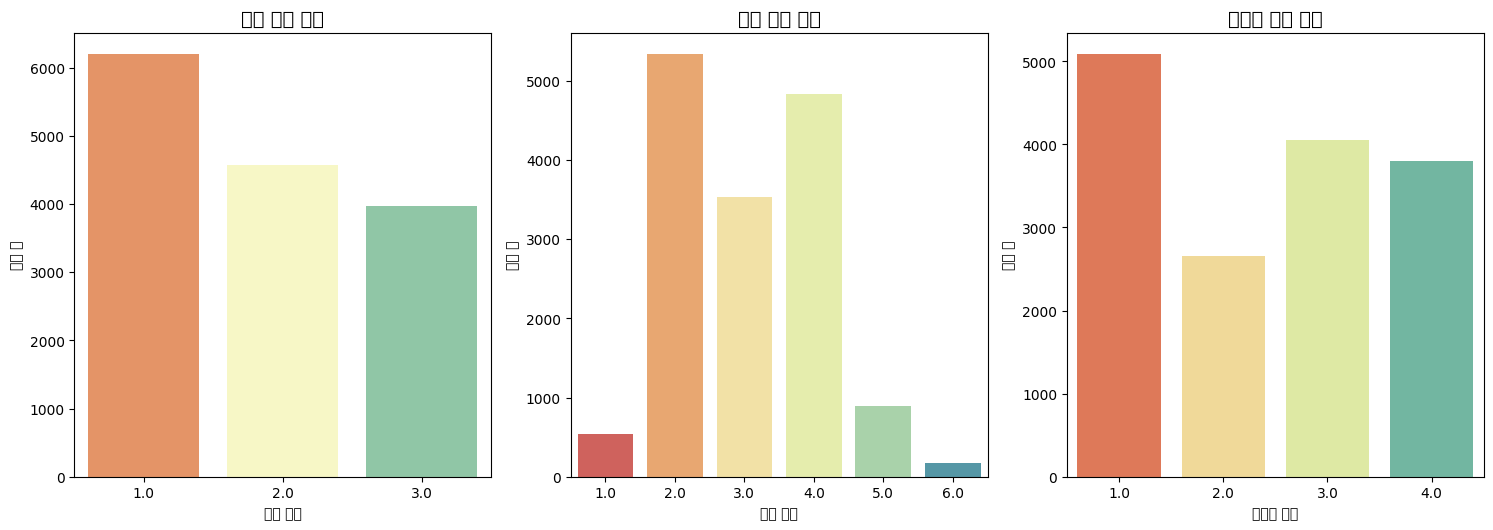

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': '당뇨 여부',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
